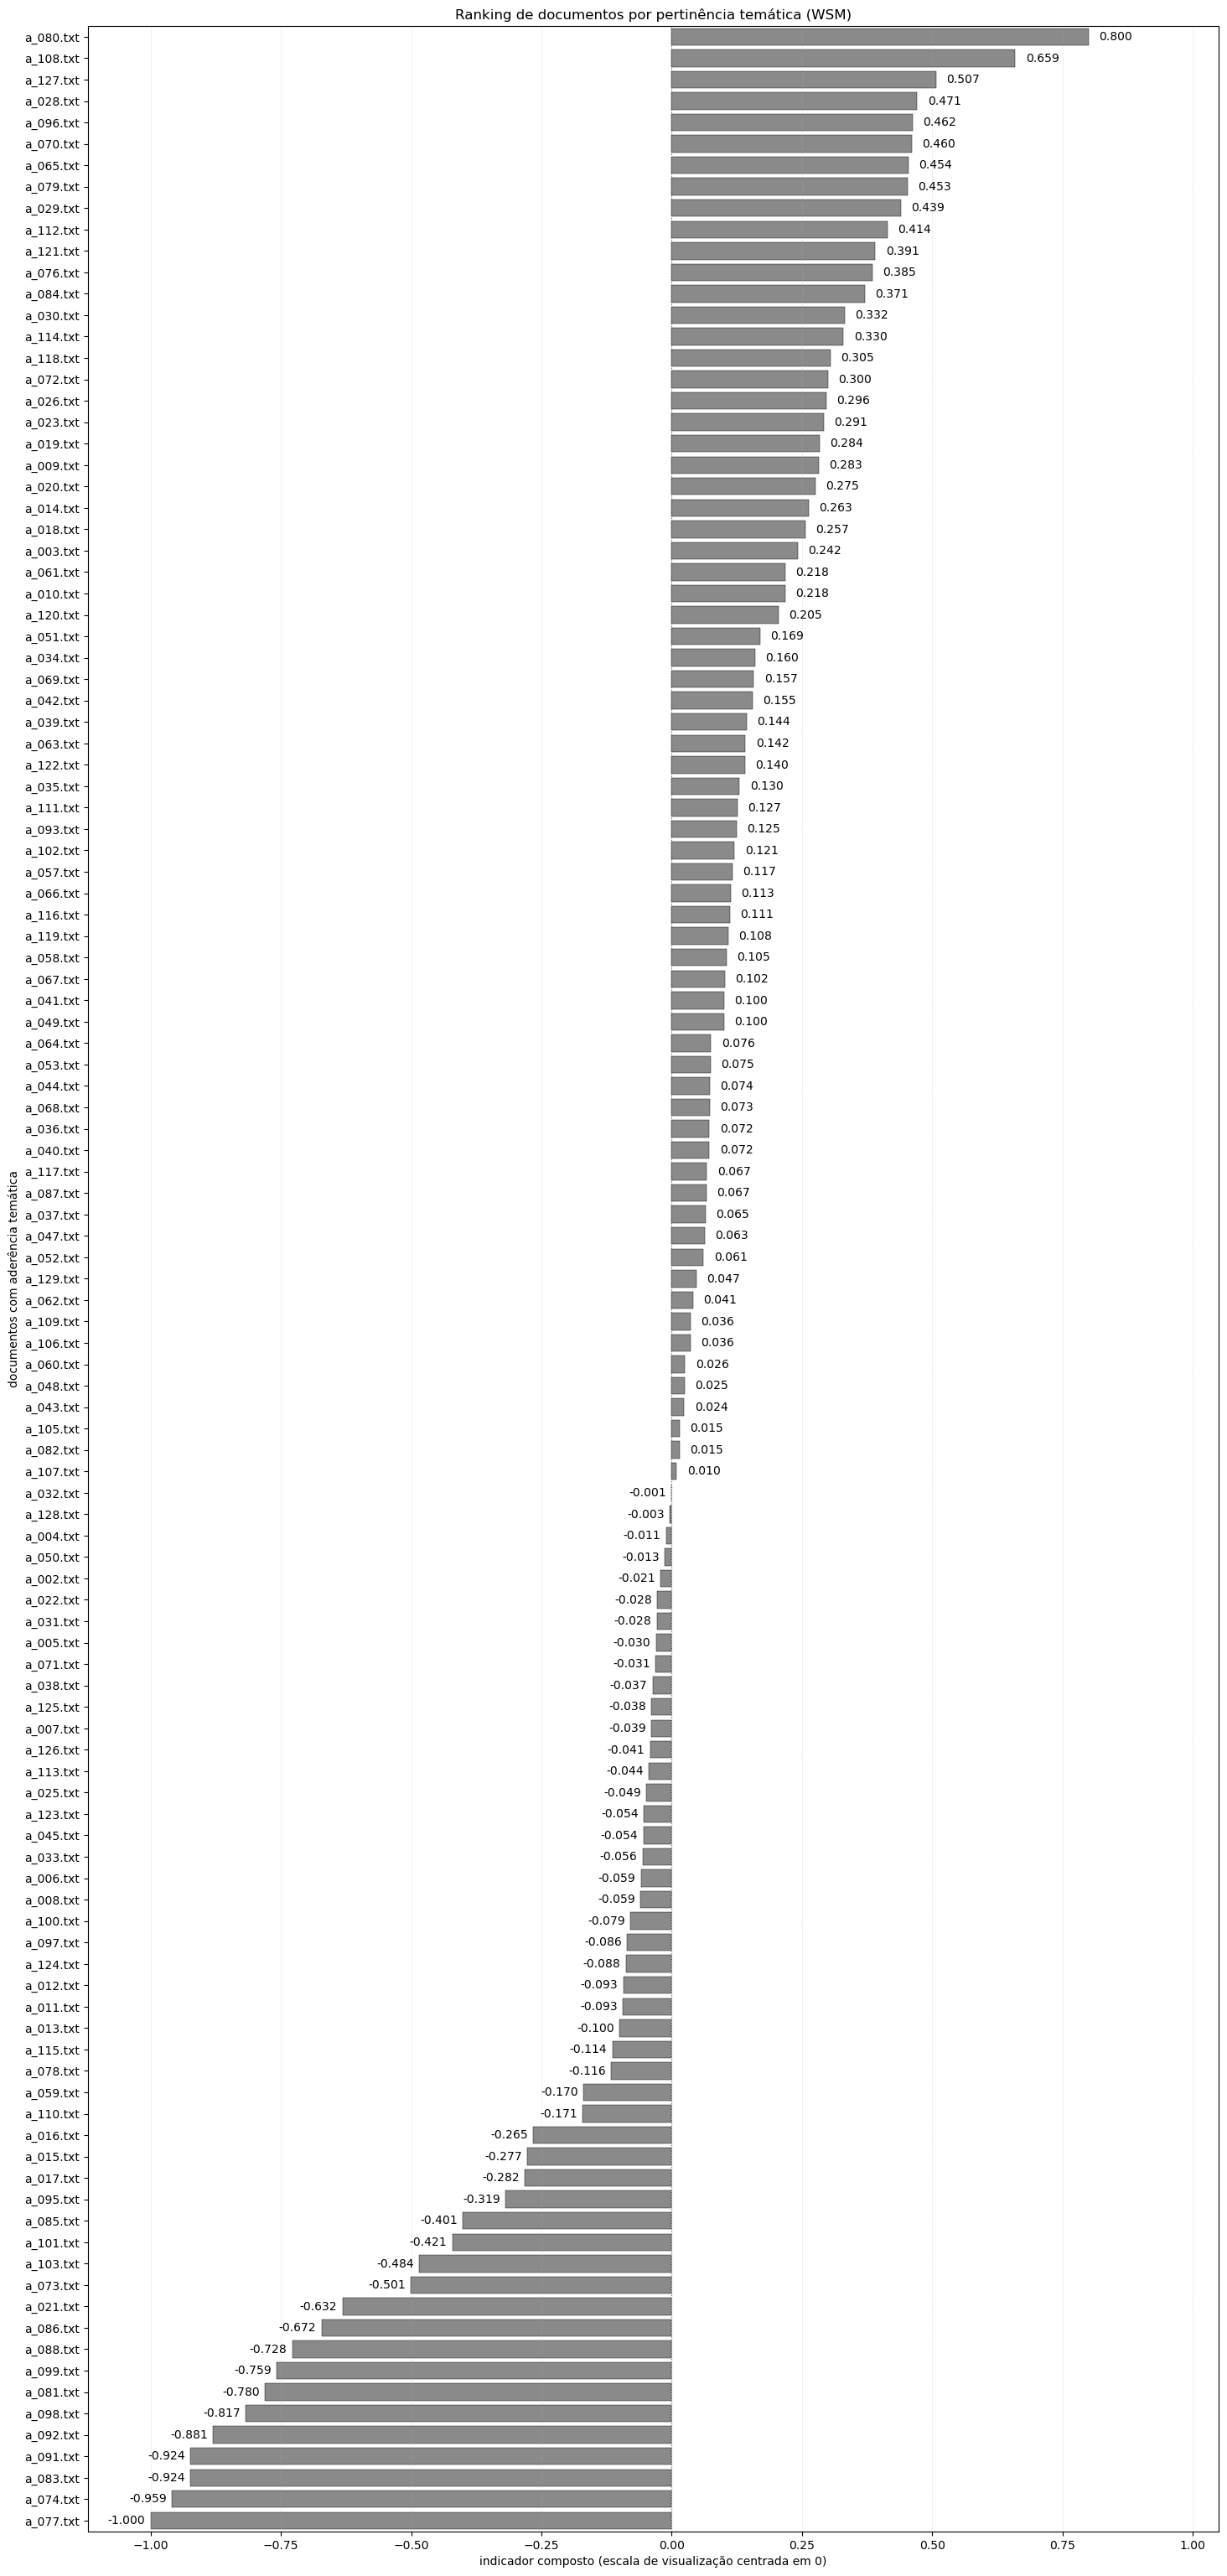

,file_name,text,bm25,semantic_cosine,coverage,diversity,bm25_z,semantic_z,coverage_z,diversity_z,wsm,wsm_vis
0,a_080.txt,ementa e acórdão inteiro teor do acórdão - pág...,20.566473,0.005824,0.161878,0.771890,1.395494,3.819997,1.168210,1.059701,1.860850,0.799976
1,a_108.txt,ementa e acórdão inteiro teor do acórdão - pág...,40.304549,0.004218,0.123326,0.696852,4.199022,1.719185,-0.300089,0.516976,1.533774,0.659366
2,a_127.txt,ementa e acórdão inteiro teor do acórdão - pág...,35.398944,0.003360,0.122469,0.756873,3.502247,0.596233,-0.332743,0.951087,1.179206,0.506938
3,a_028.txt,ementa e acórdão inteiro teor do acórdão - pág...,26.605079,0.003738,0.144863,0.697307,2.253197,1.090716,0.520173,0.520269,1.096089,0.471206
4,a_096.txt,ementa e acórdão inteiro teor do acórdão - pág...,22.429187,0.003978,0.146512,0.715838,1.660067,1.405089,0.582990,0.654295,1.075610,0.462403
...,...,...,...,...,...,...,...,...,...,...,...,...
112,a_092.txt,ementa e acórdão inteiro teor do acórdão - pág...,0.351998,0.001330,0.086675,0.216021,-1.475700,-2.060374,-1.695968,-2.960706,-2.048187,-0.880511
113,a_091.txt,ementa e acórdão inteiro teor do acórdão - pág...,0.333325,0.001160,0.082232,0.214590,-1.478352,-2.282127,-1.865195,-2.971052,-2.149181,-0.923929
114,a_083.txt,ementa e acórdão inteiro teor do acórdão - pág...,0.845628,0.001273,0.073359,0.230941,-1.405586,-2.135236,-2.203130,-2.852795,-2.149187,-0.923931
115,a_074.txt,ementa e acórdão inteiro teor do acórdão - pág...,0.769246,0.001289,0.068493,0.210013,-1.416435,-2.113644,-2.388454,-3.004159,-2.230673,-0.958962


In [1]:
from pathlib import Path
import json
import re
import math
from collections import Counter, defaultdict

import pandas as pd
import matplotlib.pyplot as plt

config_path = (
    Path.home()
    / "Documents"
    / "jurimetria_aved_stf"
    / "config"
    / "project_config.json"
)
config = json.loads(config_path.read_text(encoding="utf-8"))

thematic_dir = Path(config["paths"]["thematic_dir"]).expanduser()
ranked_dir   = Path(config["paths"]["ranked_dir"]).expanduser()
figures_dir  = Path(config["paths"]["figures_dir"]).expanduser()

thematic_dir.mkdir(parents=True, exist_ok=True)
ranked_dir.mkdir(parents=True, exist_ok=True)
figures_dir.mkdir(parents=True, exist_ok=True)

tf_conf = config.get("thematic_filter", {})

group_a_patterns = tf_conf.get("group_a_patterns", [
    "fake", "fake_news",
    "conteudo", "conteudo_falso", "conteudo_enganoso",
    "desinform", "misinform", "desordem",
    "narrativ", "fraude", "urna", "tse",
    "milicia", "milicias", "milicias_digitais",
    "gabinete", "gabinete_do_odio", "digital",
    "telegram", "whatsapp",
    "convoc", "caravana",
    "financi", "incentiv", "incit",
    "rede_social", "redes_sociais", "rede", "social",
    "perfil", "plataforma",
    "qg", "quartel", "quartel_general",
])

group_b_patterns = tf_conf.get("group_b_patterns", [
    "8_de_janeiro", "8_de_janeiro_de_2023",
    "ato_antidemocratico", "atos_antidemocraticos", "antidemocrat",
    "invasao", "invasao_de_brasilia", "brasilia",
    "depred", "destruic", "vandalismo", "patrimonio",
    "praca_dos_tres_poderes",
    "palacio_do_planalto", "planalto",
    "congresso_nacional", "congresso",
    "supremo_tribunal_federal", "stf",
    "quebra_da_ordem_democratica", "ordem_democratica",
    "golpe", "golpe_de_estado",
    "acamp", "acampamento",
    "tomar_os_tres_poderes",
])

theme_patterns = list(dict.fromkeys(group_a_patterns + group_b_patterns))
prototype_text = " ".join(theme_patterns)

thematic_files = sorted(thematic_dir.glob("*.txt"))
docs = []
for p in thematic_files:
    txt = p.read_text(encoding="utf-8", errors="ignore")
    docs.append({"file_name": p.name, "text": txt})

if not docs:
    print("Nenhum documento temático encontrado em 03_thematic.")
    raise SystemExit

df_docs = pd.DataFrame(docs)

def tokenize(text: str):
    text = text.lower()
    text = re.sub(r"[^\w\s]", " ", text)
    return [t for t in re.split(r"\s+", text) if t]

def sentence_split(text: str):
    parts = re.split(r"[\.!?;:\n]+", text)
    return [p.strip() for p in parts if p.strip()]

def contains_any_pattern(text_lower: str, patterns):
    for pat in patterns:
        if pat in text_lower:
            return True
    return False

# (i) BM25 – relevância lexical
k1 = 1.5
b  = 0.75

doc_tokens = [tokenize(row.text) for row in df_docs.itertuples()]
N = len(doc_tokens)
doc_lens = [len(t) for t in doc_tokens]
avgdl = sum(doc_lens) / N

query_terms = tokenize(prototype_text)
query_terms = list(dict.fromkeys(query_terms))

dfreq = defaultdict(int)
for toks in doc_tokens:
    uniq = set(toks)
    for qt in query_terms:
        if qt in uniq:
            dfreq[qt] += 1

def bm25_score_for_doc(toks):
    score = 0.0
    doc_len = len(toks)
    counts = Counter(toks)
    for qt in query_terms:
        if qt not in counts:
            continue
        f = counts[qt]
        n_qt = dfreq.get(qt, 0)
        idf = math.log(1 + (N - n_qt + 0.5) / (n_qt + 0.5))
        denom = f + k1 * (1 - b + b * (doc_len / avgdl))
        score += idf * (f * (k1 + 1) / denom)
    return score

df_docs["bm25"] = [bm25_score_for_doc(toks) for toks in doc_tokens]

# (ii) TF-IDF + cosseno – direcionamento semântico
try:
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.metrics.pairwise import cosine_similarity

    corpus_texts = [d["text"] for d in docs] + [prototype_text]
    vectorizer = TfidfVectorizer(lowercase=True, ngram_range=(1, 2), min_df=1)
    tfidf_matrix = vectorizer.fit_transform(corpus_texts)
    proto_vec = tfidf_matrix[-1]
    doc_vecs  = tfidf_matrix[:-1]
    cos_scores = cosine_similarity(doc_vecs, proto_vec).ravel()
except ImportError:
    cos_scores = [0.0] * len(docs)

df_docs["semantic_cosine"] = cos_scores

# (iii) cobertura temática – % de sentenças com tema
coverage_vals = []
for row in df_docs.itertuples():
    sents = sentence_split(row.text)
    if not sents:
        coverage_vals.append(0.0)
        continue
    thematic_count = 0
    for s in sents:
        if contains_any_pattern(s.lower(), theme_patterns):
            thematic_count += 1
    coverage_vals.append(thematic_count / len(sents))

df_docs["coverage"] = coverage_vals

# (iv) diversidade temática – Shannon normalizado
lex_groups = {
    "desinfo": [
        "fake", "fake_news", "conteudo", "desinform", "misinform", "narrativ",
        "fraude", "urna", "tse"
    ],
    "atos": [
        "8_de_janeiro", "8_de_janeiro_de_2023", "ato_antidemocratico",
        "atos_antidemocraticos", "invasao", "invasao_de_brasilia", "vandalismo",
        "depred", "destruic"
    ],
    "instituicoes": [
        "supremo_tribunal_federal", "stf", "congresso_nacional", "congresso",
        "palacio_do_planalto", "praca_dos_tres_poderes", "planalto"
    ],
    "mobilizacao": [
        "acamp", "acampamento", "convoc", "caravana", "financi", "incentiv",
        "incit", "tomar_os_tres_poderes"
    ],
}

diversity_vals = []
for row in df_docs.itertuples():
    toks = tokenize(row.text)
    group_counts = {g: 0 for g in lex_groups}
    for tok in toks:
        tok_low = tok.lower()
        for g, pats in lex_groups.items():
            if any(p in tok_low for p in pats):
                group_counts[g] += 1
    total = sum(group_counts.values())
    if total == 0:
        diversity_vals.append(0.0)
    else:
        probs = [c / total for c in group_counts.values() if c > 0]
        H = -sum(p * math.log(p) for p in probs)
        H_max = math.log(len(lex_groups))
        H_norm = H / H_max if H_max > 0 else 0.0
        diversity_vals.append(H_norm)

df_docs["diversity"] = diversity_vals

# z-score por critério
def zscore(series: pd.Series):
    mean = series.mean()
    std = series.std()
    if std == 0 or pd.isna(std):
        return series - mean
    return (series - mean) / std

df_docs["bm25_z"]      = zscore(df_docs["bm25"])
df_docs["semantic_z"]  = zscore(df_docs["semantic_cosine"])
df_docs["coverage_z"]  = zscore(df_docs["coverage"])
df_docs["diversity_z"] = zscore(df_docs["diversity"])

# WSM – soma ponderada
w_bm25 = 0.25
w_sem  = 0.25
w_cov  = 0.25
w_div  = 0.25

df_docs["wsm"] = (
    df_docs["bm25_z"]      * w_bm25 +
    df_docs["semantic_z"]  * w_sem  +
    df_docs["coverage_z"]  * w_cov  +
    df_docs["diversity_z"] * w_div
)

# Visualização (centrada em 0)
max_abs = df_docs["wsm"].abs().max()
if max_abs > 0:
    df_docs["wsm_vis"] = df_docs["wsm"] / max_abs
else:
    df_docs["wsm_vis"] = 0.0

df_ranked = df_docs.sort_values(by="wsm", ascending=False).reset_index(drop=True)

df_ranked.to_csv(ranked_dir / "thematic_ranking.csv", index=False)
try:
    df_ranked.to_parquet(ranked_dir / "thematic_ranking.parquet", index=False)
except Exception as e:
    print("Não foi possível salvar parquet:", e)

MAX_LABEL = 65
display_labels = []
for name in df_ranked["file_name"]:
    if len(name) <= MAX_LABEL:
        display_labels.append(name)
    else:
        display_labels.append(name[:MAX_LABEL - 3] + "...")

n_docs = len(df_ranked)
height = max(4, 0.28 * n_docs + 1.2)

fig, ax = plt.subplots(figsize=(19, height))

ax.barh(
    display_labels,
    df_ranked["wsm_vis"],
    color="#8a8a8a",
    edgecolor="black",
    linewidth=0.3,
)

ax.set_title("Ranking de documentos por pertinência temática (WSM)")
ax.set_xlabel("indicador composto (escala de visualização centrada em 0)")
ax.set_ylabel("documentos com aderência temática")

ax.set_xlim(-1.12, 1.05)
ax.set_ylim(-0.5, n_docs - 0.5)

ax.axvline(0, color="#555555", linewidth=0.9, linestyle=":", alpha=0.85)
ax.grid(axis="x", linestyle="--", linewidth=0.4, alpha=0.45)
ax.invert_yaxis()

for i, val in enumerate(df_ranked["wsm_vis"]):
    txt = f"{val:.3f}"
    if val >= 0:
        x_text = min(val + 0.02, 1.02)
        ha = "left"
    else:
        x_text = max(val - 0.01, -1.08)
        ha = "right"
    ax.text(x_text, i, txt, va="center", ha=ha)

# como os rótulos estão curtos, a margem pode ser pequena
plt.subplots_adjust(left=0.28, right=0.99, top=0.93, bottom=0.05)

fig.savefig(figures_dir / "thematic_ranking.png", dpi=150)
plt.show()

df_ranked